In [1]:
import pandas as pd
import numpy as np
import os
import re
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


In [2]:

# Load the CSV file
params = pd.read_csv(r'C:\Users\maya620d\PycharmProjects\Spermatogensis\ad_hoc\Breathing_Parameters.txt', header=None)

current_date = '2024-06-09'
# Base directory
# base_dir = f"Y:/05_Projekte/manish/Spermatogensis/results/Output/Experiment/Nucleosome_Breathing/All/{current_date}/"
base_dir = r"C:\Users\maya620d\PycharmProjects\Spermatogensis\Cluster_Results\Output\Experiment\Nucleosome_Breathing\All\/" + f"{current_date}"

In [3]:

if os.path.exists("Y:/"):
    print("The directory is mounted.")
else:
    print("The directory is not mounted.")

The directory is mounted.


In [4]:
base_dir

'C:\\Users\\maya620d\\PycharmProjects\\Spermatogensis\\Cluster_Results\\Output\\Experiment\\Nucleosome_Breathing\\All\\/2024-06-09'

In [5]:

def process_directories(base_dir):
    # Get the immediate subdirectories
    _, subdirs, _ = next(os.walk(base_dir))

    # Define the regular expression pattern
    pattern = r'K_UNWRAP=(\d+\.\d+)_K_WRAP=(\d+\.\d+)_P_CONC=(\d+\.\d+)_CO_(\d+\.\d+)'

    # Dictionary to store the parameters and corresponding subdirectories
    parameters_dict = {}

    # Process each subdirectory separately
    for subdir in subdirs:
        subdir_path = os.path.join(base_dir, subdir)

        # Extract the values using regex
        match = re.search(pattern, subdir_path)

        if match:
            K_UNWRAP = float(match.group(1))
            K_WRAP = float(match.group(2))
            P_CONC = float(match.group(3))
            COOPERATIVITY = float(match.group(4))

            # Store the parameters and corresponding subdirectory in the dictionary
            parameters_dict[(K_UNWRAP, K_WRAP, P_CONC, COOPERATIVITY)] = subdir_path

    return parameters_dict

def process_files(subdir_path):

    Closed_evol = []
    Times =  []
    Nuc_lifetime =  []

    for root, _, files in os.walk(subdir_path):
        sorted_files = sorted(files, key=lambda x: int(x.split('_')[0]))
        # Read the numpy files in the sorted order
        for file in sorted_files:
            file_path = os.path.join(root, file)
            data = np.load(file_path)
            # print(file.split('_'))
            if file.split('_')[1] == 'closed':
                Closed_evol.append(data)
            elif file.split('_')[1] == 'times.npy':
                Times.append(data)
            elif file.split('_')[2] == 'lifetime.npy':
                Nuc_lifetime.append(data)
    print(f"Finished processing all files in directory: {subdir_path}")


    return Closed_evol, Times, Nuc_lifetime



In [6]:
param_dict = process_directories(base_dir=base_dir)

In [8]:
def trajectory_evolution_plot(closed_evol_d, times_d, title, n_bin=100, plotting=False):
    warnings.filterwarnings('ignore')
    dfs = []
    for i, j in zip(closed_evol_d, times_d):
        df = pd.DataFrame({
            'Times': j,
            'Closed Evolution': i
        })

        # Do something with the dataframe
        df['Time_diff'] = df.groupby('Closed Evolution')['Times'].diff()
        # Replace nan values in Time_diff with corresponding Time values
        df['Time_diff'].fillna(df['Times'], inplace=True)

        dfs.append(df)


    # Concatenate all the DataFrames together
    df = pd.concat(dfs)
    data_stats =df.groupby('Closed Evolution')['Time_diff'].agg(
            mean='mean',
            var='var',
            count='count'
        )

    data_stats.reset_index(inplace=True)
    # Define the bins for the time data
    max_time = df['Times'].max()
    num_bins = n_bin  # adjust this value as needed
    bins = np.linspace(0, max_time, num_bins)
    # Bin the time data
    df['Time Bins'] = pd.cut(df['Times'], bins=bins, include_lowest=True)

    # Calculate the mean 'Closed Evolution' value for each bin
    grouped = df.groupby('Time Bins')['Closed Evolution']
    mean_trajectory = grouped.mean()
    std_trajectory = grouped.std()


    df_bin_trajectory = pd.DataFrame({'Time': bins[:-1], 'Trajectory': mean_trajectory.values, 'Std': std_trajectory.values, 'Count': grouped.count().values})
    # print(df_bin_trajectory)
    # # Plot each trajectory
    # for i, j in zip(closed_evol, times):
    #     sns.lineplot(x=j, y=i, color='gray', alpha=0.1, legend=False)

    # Plot the mean trajectory
    # sns.lineplot(x=bins[:-1], y=mean_trajectory.values, color='red')
    # # Plot the confidence interval
    # plt.fill_between(bins[:-1], (mean_trajectory-std_trajectory).values, (mean_trajectory+std_trajectory).values, color='red', alpha=0.3)

    # plt.xlabel('Times')
    # plt.ylabel('Closed Evolution')
    # plt.title(title)
    # plt.show()

    return data_stats, df_bin_trajectory

In [9]:
All_grouped_data = pd.DataFrame()
All_Time_bin_data = pd.DataFrame()
All_nuc_lifetime = pd.DataFrame()

warnings.filterwarnings('ignore')
for key, value in param_dict.items():
    print(f"Key: {key}, Value: {value}")

    # if key[1] in selected_rewrapping_rates and key[2] in selected_concentrations and  key[3] in selected_coop:
    closed_evol, times, nuc_lifetime = process_files(subdir_path=value)
    title =  'Rewrapping rate ' + str(key[1]) + 'Concentration ' + str(key[2]) + 'Cooperativity ' + str(key[3])

    flattened_nuc_lifetime = np.concatenate(nuc_lifetime)
    nuc_life_DF = pd.DataFrame(flattened_nuc_lifetime, columns=['Nucleosome_lifetime'])
    nuc_life_DF['Rewrapping_rate'] = key[1]
    nuc_life_DF['Concentration'] = key[2]
    nuc_life_DF['Cooperativity'] = key[3]

    All_nuc_lifetime = pd.concat([All_nuc_lifetime, nuc_life_DF], axis=0)
    


    Data_Stat, Time_bin_data = trajectory_evolution_plot(closed_evol, times, title, n_bin=100, plotting=False)
    Time_bin_data['Rewrapping_rate'] = key[1]
    Time_bin_data['Concentration'] = key[2]
    Time_bin_data['Cooperativity'] = key[3]
    Time_bin_data = Time_bin_data.dropna()

    Data_Stat['Rewrapping_rate'] = key[1]
    Data_Stat['Concentration'] = key[2]
    Data_Stat['Cooperativity'] = key[3]
    
    # grouped_data = plot_trajectories(closed_evol, times, title, rewrapping_rate=key[1], period=1, plotting=True)
    All_grouped_data = pd.concat([All_grouped_data, Data_Stat], axis=0)
    All_Time_bin_data = pd.concat([All_Time_bin_data, Time_bin_data], axis=0)
        # print(All_Time_bin_data)


Key: (210.0, 1130.0, 0.0, 0.0), Value: C:\Users\maya620d\PycharmProjects\Spermatogensis\Cluster_Results\Output\Experiment\Nucleosome_Breathing\All\/2024-06-09\K_UNWRAP=210.00_K_WRAP=1130.00_P_CONC=0.00_CO_0.0_NUC_1_REP_1
Finished processing all files in directory: C:\Users\maya620d\PycharmProjects\Spermatogensis\Cluster_Results\Output\Experiment\Nucleosome_Breathing\All\/2024-06-09\K_UNWRAP=210.00_K_WRAP=1130.00_P_CONC=0.00_CO_0.0_NUC_1_REP_1
Key: (210.0, 1330.0, 0.0, 0.0), Value: C:\Users\maya620d\PycharmProjects\Spermatogensis\Cluster_Results\Output\Experiment\Nucleosome_Breathing\All\/2024-06-09\K_UNWRAP=210.00_K_WRAP=1330.00_P_CONC=0.00_CO_0.0_NUC_1_REP_1
Finished processing all files in directory: C:\Users\maya620d\PycharmProjects\Spermatogensis\Cluster_Results\Output\Experiment\Nucleosome_Breathing\All\/2024-06-09\K_UNWRAP=210.00_K_WRAP=1330.00_P_CONC=0.00_CO_0.0_NUC_1_REP_1
Key: (210.0, 1530.0, 0.0, 0.0), Value: C:\Users\maya620d\PycharmProjects\Spermatogensis\Cluster_Results\Ou

In [11]:
All_Time_bin_data

,Time,Trajectory,Std,Count,Rewrapping_rate,Concentration,Cooperativity
0,0.000000,13.072036,0.859306,10231,1130.0,0.0,0.0
1,12.004304,13.035245,0.911425,10271,1130.0,0.0,0.0
2,24.008608,13.064526,0.867852,10027,1130.0,0.0,0.0
3,36.012911,13.034043,0.907462,9958,1130.0,0.0,0.0
4,48.017215,13.025719,0.928594,10187,1130.0,0.0,0.0
...,...,...,...,...,...,...,...
94,1128.504224,12.906353,0.986721,9995,930.0,0.0,0.0
95,1140.509589,12.915945,1.010949,10041,930.0,0.0,0.0
96,1152.514953,12.854175,1.046124,10300,930.0,0.0,0.0
97,1164.520317,12.902177,1.033046,10059,930.0,0.0,0.0


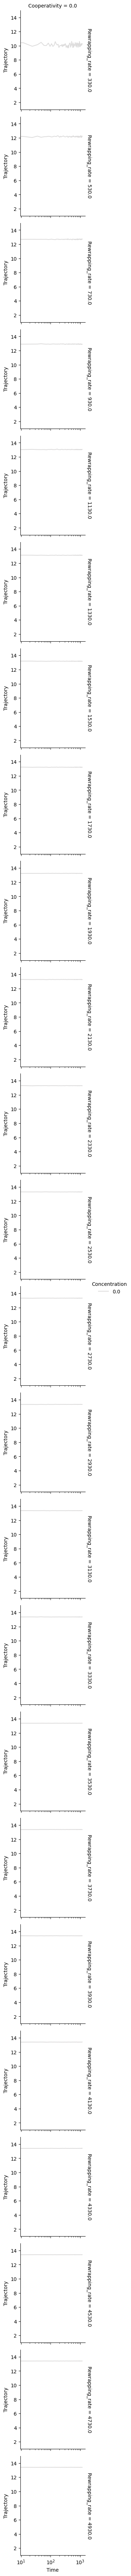

In [12]:
# Create a FacetGrid to separate plots by concentration or rewrapping rate
g = sns.FacetGrid(All_Time_bin_data, 
                  col="Cooperativity", 
                  row="Rewrapping_rate", 
                  hue="Concentration", 
                  palette="coolwarm", 
                  margin_titles=True)

g.map(sns.lineplot, "Time", "Trajectory")
g.add_legend()

# # Logarithmic scale for better visualization
# for ax in g.axes.flat:
#     ax.set_yscale('log')
#     ax.set_ylim(1, 15)
#     # Logarithmic scale for better visualization
for ax in g.axes.flat:
    ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.set_ylim(1, 15)

plt.show()

In [ ]:

# Create a FacetGrid to separate plots by cooperativity (rows) and concentration (columns)
g = sns.FacetGrid(All_grouped_data, col="Concentration", row="Cooperativity", hue="Rewrapping_rate", palette="coolwarm", margin_titles=True)
g.map(sns.lineplot, "Closed Evolution", "mean", marker="o")
g.add_legend()

# Logarithmic scale for better visualization
for ax in g.axes.flat:
    ax.set_yscale('log')
    # ax.set_ylim(1e-3, 1e2)

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Mean vs Closed Evolution with Rewrapping Rates')
# Reverse the x-axis
plt.gca().invert_xaxis()
plt.show()

In [13]:
selected_rewrap_list = [330.0, 730.0, 1330.0, 2330.0, 3330.0, 4330.0, 4930.0]

In [16]:
All_grouped_data

,Closed Evolution,mean,var,count,Rewrapping_rate,Concentration,Cooperativity
0,5,484.098964,NaN,1,1130.0,0.0,0.0
1,6,37.391585,1942.190722,29,1130.0,0.0,0.0
2,7,8.846453,157.379267,132,1130.0,0.0,0.0
3,8,2.194884,8.539961,538,1130.0,0.0,0.0
4,9,0.477381,0.468321,2489,1130.0,0.0,0.0
...,...,...,...,...,...,...,...
8,10,0.066517,0.011291,17868,930.0,0.0,0.0
9,11,0.019832,0.000916,59931,930.0,0.0,0.0
10,12,0.006565,0.000071,181039,930.0,0.0,0.0
11,13,0.002735,0.000006,434633,930.0,0.0,0.0


In [23]:
selected_rewrap_list

[330.0, 730.0, 1330.0, 2330.0, 3330.0, 4330.0, 4930.0]

In [26]:
selected_rewrap_list_ = [330.0, 1330.0, 4930.0]

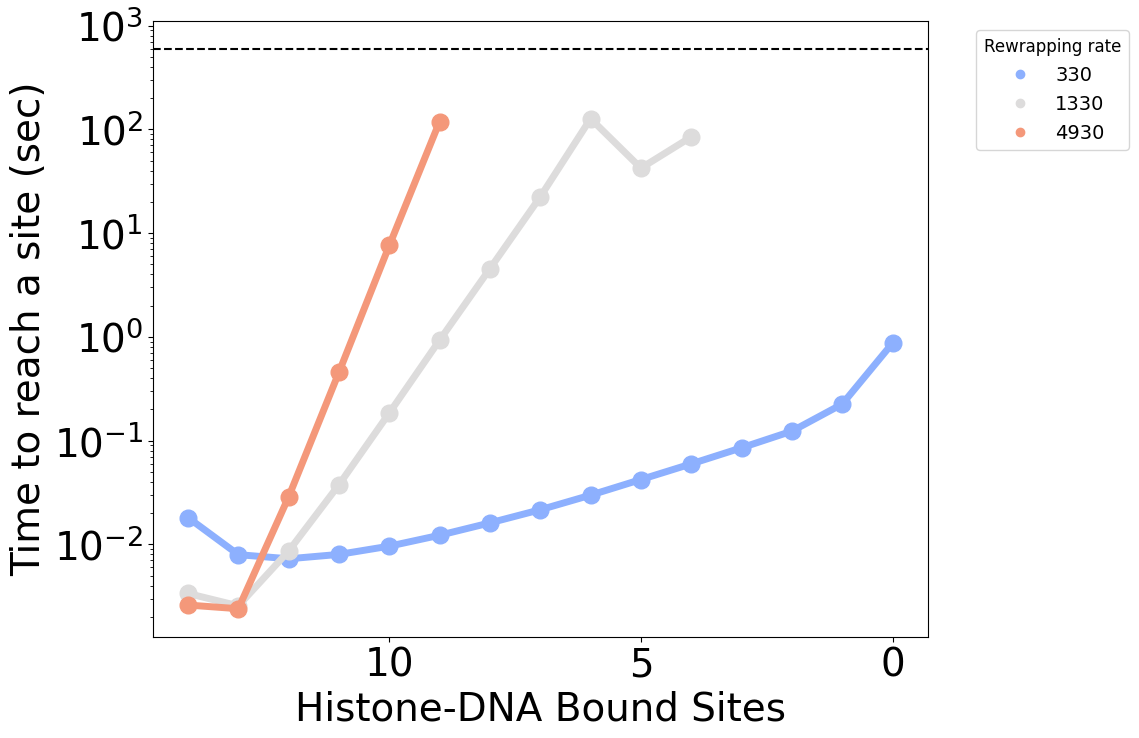

In [31]:

# import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.lines as mlines

#  Plot the data
plt.figure(figsize=(10, 8))
palette = sns.color_palette("coolwarm", len(selected_rewrap_list_))

# Plot the data
for i, rewrapping_rate in enumerate(selected_rewrap_list_):
    data = All_grouped_data[All_grouped_data['Rewrapping_rate'] == rewrapping_rate]
    plt.plot(data['Closed Evolution'], data['mean'], color=palette[i], linewidth=5, marker='o', label=rewrapping_rate, markersize=12)
    # plt.fill_between(data['Trajectory'], data['mean'] - data['var'], data['mean'] + data['var'], color=palette[i], alpha=0)

# Create custom legend handles and labels
handles = [mlines.Line2D([], [], color=palette[i], marker='o', linestyle='', label=int(round(rewrapping_rate))) for i, rewrapping_rate in enumerate(selected_rewrap_list_)]
labels = [int(round(rewrapping_rate)) for rewrapping_rate in selected_rewrap_list_]

# Add the custom legend with a title
plt.legend(handles=handles, labels=labels, title='Rewrapping rate',  title_fontsize='large', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
plt.axhline(600, color='black', linestyle='--')

# # Set the y-axis to log scale
plt.yscale('log')
plt.tick_params(axis='both', which='both', labelsize=28)

# Set the x-axis label
plt.xlabel('Histone-DNA Bound Sites', fontsize=28)
# Set the y-axis label
plt.ylabel("Time to reach a site (sec)", fontsize=28)

# Set the title
# plt.title('Mean vs Trajectory with Rewrapping Rates')
plt.gca().invert_xaxis()

plt.show()

In [37]:
def plot_trajectories(closed_evol, times, title, rewrapping_rate, period=10, plotting=False):
    # Ignore warnings
    warnings.filterwarnings('ignore')

    # Calculate the mean trajectory and times
    max_len = max(len(x) for x in closed_evol)
    mean_trajectory = [np.mean([x[i] for x in closed_evol if i < len(x)]) for i in range(max_len)]
    mean_times = [np.mean([x[i] for x in times if i < len(x)]) for i in range(max_len)]


    # Convert trajectory and times to a dataframe
    df = pd.DataFrame({'Time': mean_times, 'Trajectory': mean_trajectory})

    # Do something with the dataframe
    df['Time_diff'] = df.groupby('Trajectory')['Time'].diff()
    # Replace nan values in Time_diff with corresponding Time values
    df['Time_diff'].fillna(df['Time'], inplace=True)
    # Example: Print the dataframe
    
    # print(df)
    # Calculate the mean Time_diff, variance, and count of values in each group
    grouped_data = df.groupby('Trajectory')['Time_diff'].agg(
                                                                mean='mean',
                                                                var='var',
                                                                count='count'
                                                            )
    
    grouped_data = grouped_data.reset_index()
    grouped_data['Rewrapping_rate'] = rewrapping_rate

    # # Convert the grouped data to a dataframe
    # grouped_df = pd.DataFrame(grouped_data)



    # print(grouped_data)
    


    if plotting:
        # Create a new plot
        plt.figure(figsize=(10, 6))

        # # Plot each trajectory
        # for i in range(len(closed_evol)):
        #     sns.lineplot(x=times[i], y=closed_evol[i], alpha=0.5, color='gray', legend=False)

        # Plot the mean trajectory
        sns.lineplot(x=mean_times[::period], y=mean_trajectory[::period], color='red')

        plt.xlabel('Time (seconds)')
        plt.ylabel('Total Number of binding sites bound to histone')
        plt.title(title)
        plt.savefig('./Breathing_plots/'+title+'.png')
        plt.close()
    return grouped_data

In [39]:
All_grouped_data = pd.DataFrame()

for key, value in param_dict.items():
    print(f"Key: {key}, Value: {value}")

    closed_evol, times, nuc_lifetime = process_files(subdir_path=value)
    title =  'Rewrapping rate ' + str(key[1])
    grouped_data = plot_trajectories(closed_evol, times, title, rewrapping_rate=key[1], period=100)
    All_grouped_data = pd.concat([All_grouped_data, grouped_data], axis=0)
    # print(All_grouped_data)

Key: (210.0, 1130.0, 0.0, 0.0), Value: C:\Users\maya620d\PycharmProjects\Spermatogensis\Cluster_Results\Output\Experiment\Nucleosome_Breathing\All\/2024-06-09\K_UNWRAP=210.00_K_WRAP=1130.00_P_CONC=0.00_CO_0.0_NUC_1_REP_1
Finished processing all files in directory: C:\Users\maya620d\PycharmProjects\Spermatogensis\Cluster_Results\Output\Experiment\Nucleosome_Breathing\All\/2024-06-09\K_UNWRAP=210.00_K_WRAP=1130.00_P_CONC=0.00_CO_0.0_NUC_1_REP_1
Key: (210.0, 1330.0, 0.0, 0.0), Value: C:\Users\maya620d\PycharmProjects\Spermatogensis\Cluster_Results\Output\Experiment\Nucleosome_Breathing\All\/2024-06-09\K_UNWRAP=210.00_K_WRAP=1330.00_P_CONC=0.00_CO_0.0_NUC_1_REP_1
Finished processing all files in directory: C:\Users\maya620d\PycharmProjects\Spermatogensis\Cluster_Results\Output\Experiment\Nucleosome_Breathing\All\/2024-06-09\K_UNWRAP=210.00_K_WRAP=1330.00_P_CONC=0.00_CO_0.0_NUC_1_REP_1
Key: (210.0, 1530.0, 0.0, 0.0), Value: C:\Users\maya620d\PycharmProjects\Spermatogensis\Cluster_Results\Ou

In [65]:
rewrap_list = All_grouped_data['Rewrapping_rate'].unique().tolist()
rewrap_list.sort()

In [88]:
rewrap_list

[330.0,
 530.0,
 730.0,
 930.0,
 1130.0,
 1330.0,
 1530.0,
 1730.0,
 1930.0,
 2130.0,
 2330.0,
 2530.0,
 2730.0,
 2930.0,
 3130.0,
 3330.0,
 3530.0,
 3730.0,
 3930.0,
 4130.0,
 4330.0,
 4530.0,
 4730.0,
 4930.0]

In [89]:
selected_rewrap_list =  [330.0, 530, 730.0, 1330.0, 2330.0, 3330.0, 4330.0, 4930.0]

In [93]:
All_grouped_data[All_grouped_data['Rewrapping_rate'].isin(selected_rewrap_list)]

,Trajectory,mean,var,count,Rewrapping_rate,log_count,weighted_mean,count_percent
0,4.0,84.714946,NaN,1,1330.0,0.000000,84.714946,0.0001
1,5.0,42.357480,3588.238451,2,1330.0,0.693147,84.714960,0.0002
2,6.0,126.972497,23281.931794,8,1330.0,2.079442,1015.779978,0.0008
3,7.0,22.394188,928.542634,53,1330.0,3.970292,1186.891962,0.0053
4,8.0,4.548552,51.759418,261,1330.0,5.564520,1187.171958,0.0261
...,...,...,...,...,...,...,...,...
9,10.0,0.035994,0.003894,33111,730.0,10.407621,1191.804441,3.3111
10,11.0,0.013707,0.000469,86951,730.0,11.373100,1191.821248,8.6951
11,12.0,0.005713,0.000051,208631,730.0,12.248322,1191.890768,20.8631
12,13.0,0.002983,0.000007,399579,730.0,12.898167,1191.905044,39.9579


In [100]:
selected_rewrap_list

[330.0, 530, 730.0, 1330.0, 2330.0, 3330.0, 4330.0, 4930.0]

In [121]:
# Filter out rows where 'count' is 1
All_grouped_data_ = All_grouped_data[All_grouped_data['count'] != 1]

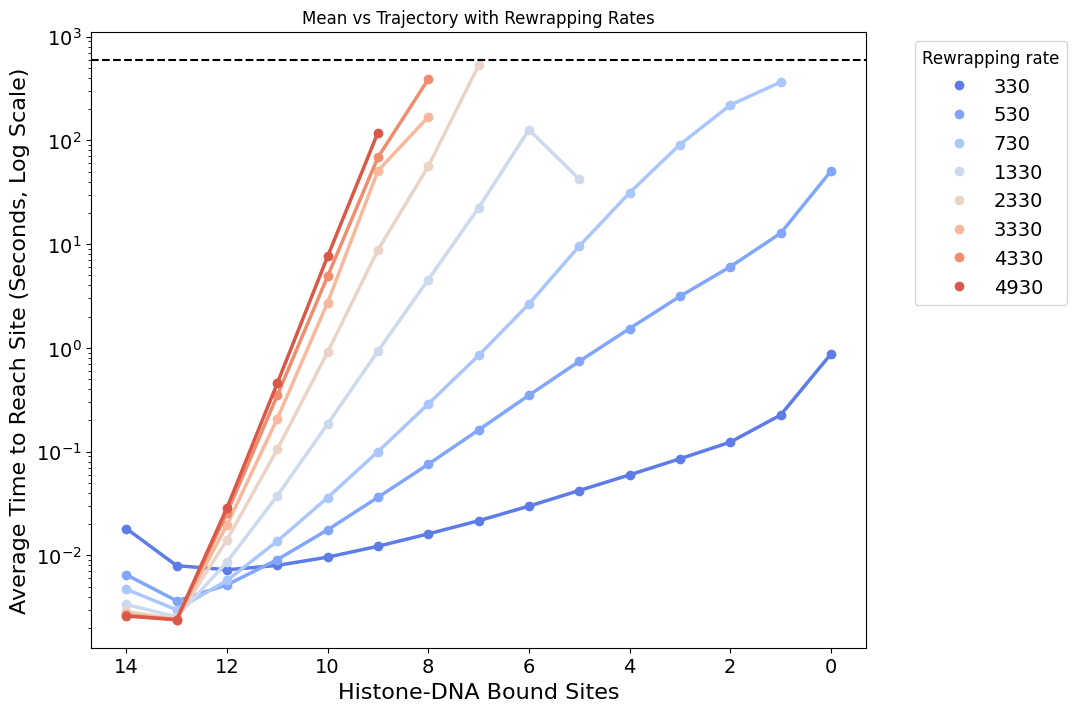

In [150]:

# import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.lines as mlines



#  Plot the data
plt.figure(figsize=(10, 8))
palette = sns.color_palette("coolwarm", len(selected_rewrap_list))

# Plot the data
for i, rewrapping_rate in enumerate(selected_rewrap_list):
    data = All_grouped_data_[All_grouped_data_['Rewrapping_rate'] == rewrapping_rate]
    plt.plot(data['Trajectory'], data['mean'], color=palette[i], linewidth=2.5, marker='o', label=rewrapping_rate)
    # plt.fill_between(data['Trajectory'], data['mean'] - data['var'], data['mean'] + data['var'], color=palette[i], alpha=0)



# Create custom legend handles and labels
handles = [mlines.Line2D([], [], color=palette[i], marker='o', linestyle='', label=int(round(rewrapping_rate))) for i, rewrapping_rate in enumerate(selected_rewrap_list)]
labels = [int(round(rewrapping_rate)) for rewrapping_rate in selected_rewrap_list]

# Add the custom legend with a title
plt.legend(handles=handles, labels=labels, title='Rewrapping rate',  title_fontsize='large', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)

# scatter = sns.lineplot(data=All_grouped_data_[All_grouped_data_['Rewrapping_rate'].isin(selected_rewrap_list)], 
#                           x='Trajectory', 
#                           y='mean',  
#                           hue='Rewrapping_rate', 
#                           legend='full', palette=palette, linewidth=2.5, 
#                           marker='o')

# Add a horizontal dashed line at y=600
plt.axhline(600, color='black', linestyle='--')


# # Set the y-axis to log scale
plt.yscale('log')

# # Set the y-axis major and minor locators and formatters
# plt.gca().yaxis.set_major_locator(ticker.LogLocator(base=10.0))
# plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10.0))
# plt.gca().yaxis.set_major_formatter(ticker.LogFormatterSciNotation())
# plt.gca().yaxis.set_minor_formatter(ticker.NullFormatter())

plt.tick_params(axis='both', which='both', labelsize=14)

# Set the x-axis label
plt.xlabel('Histone-DNA Bound Sites', fontsize=16)

# Set the y-axis label
plt.ylabel("q Time to Reach Site (Seconds, Log Scale)", fontsize=16)

# Set the title
plt.title('Mean vs Trajectory with Rewrapping Rates')


# Reverse the x-axis
plt.gca().invert_xaxis()
# Place the legend outside the plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

In [126]:
All_grouped_data

,Trajectory,mean,var,count,Rewrapping_rate,log_count,weighted_mean,count_percent
0,5.0,484.098964,NaN,1,1130.0,0.000000,484.098964,0.0001
1,6.0,37.391585,1942.190722,29,1130.0,3.367296,1084.355978,0.0029
2,7.0,8.846453,157.379267,132,1130.0,4.882802,1167.731797,0.0132
3,8.0,2.194884,8.539961,538,1130.0,6.287859,1180.847494,0.0538
4,9.0,0.477381,0.468321,2489,1130.0,7.819636,1188.200327,0.2489
...,...,...,...,...,...,...,...,...
8,10.0,0.066517,0.011291,17868,930.0,9.790767,1188.528873,1.7868
9,11.0,0.019832,0.000916,59931,930.0,11.000949,1188.528920,5.9931
10,12.0,0.006565,0.000071,181039,930.0,12.106468,1188.530348,18.1039
11,13.0,0.002735,0.000006,434633,930.0,12.982257,1188.530994,43.4633
